### Initialization

In [1]:
import glob
import json
import re
import numpy
import pandas
import time

In [2]:
from utils.text_extraction import *
from utils.document_processing import *
from utils.subject_extraction import *
from utils.similarity import *
from utils.context_extraction import *

In [3]:
import psycopg2
psycopg2_conn = psycopg2.connect(dbname='public_contracts', user='postgres', password='admin', host='localhost', port='5432')

### Subject context

In [4]:
from utils.context_extraction import *

In [5]:
from utils.similarity import *

In [6]:
from utils.evaluation import *

### EvaluationMachine

In [7]:
class SubjectContextSelectionEvaluationMachine():
    
    _contracts = None
    _df_contracts = None
    _subj_context_extractor = None
    _func_params = None
    
    def __init__(self, contracts, subj_context_extractor=SubjectContextExtractor, func_params={}):
        self._contracts = contracts
        self._subj_context_extractor = subj_context_extractor
        self._func_params = func_params
    
    def process(self):
        for contr in self._contracts:
            contr_text = contr['text']
            contr['subj_context'] = self._subj_context_extractor(**self._func_params).get_subject_context(contr_text)
        self._df_contracts = pandas.DataFrame(self._contracts).set_index('id')
        return self._df_contracts
    
    def evaluate(self):
        return self._df_contracts['subj_context'].isna().sum()

In [8]:
class ComplexSubjectContextSelectionEvaluationMachine(SubjectContextSelectionEvaluationMachine):
    
    _path_to_data = None
    _validator = None
    
    def __init__(self, path_to_data, validator=validate_subj_contexts, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._path_to_data = path_to_data
        self._validator = validator
    
    def process(self):
        super().process()
        self._df_contracts = self._validator(self._df_contracts, self._path_to_data)
        self._df_contracts['valid']=False
        df_tmp = self._df_contracts[self._df_contracts.valid_rat>0.5].copy()
        df_tmp['valid']=True
        self._df_contracts['valid']=df_tmp['valid']
        return self._df_contracts
        
    def evaluate(self):
        return self._df_contracts['valid_rat'].mean()*100

In [9]:
class ContextExtractionEvaluationMachine:
    
    def __init__(self, df_contracts, subj_context_extractor=AdvancedSubjectContextExtractor(), validator=validate_subjects):
        self._df_contracts = df_contracts
        self._subj_context_extractor = subj_context_extractor
        self._validator = validator
        
    def preprocess(self):
        self._df_contracts['subj_context'] = self._df_contracts['text'].apply(\
            lambda text: self._subj_context_extractor.process(text))
        return self._df_contracts
    
    def process(self):
        self._df_contracts = self._validator(self._df_contracts, 'subj_context')
        return self._df_contracts

    def evaluate(self):
        return self._df_contracts['valid_score'].mean()*100

### Documents 

In [10]:
from utils.document_processing import *

In [11]:
loader = DatabaseDocumentLoader(psycopg2_conn)
loader.load_documents()
documents = loader.prepare_documents()

Running query: select * from document where processed=True
Preparing total 1008 documents
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
Progress: 100.0%


In [12]:
vzdirs = '../../test-data/*/*/*/*'
ignore_contracts = ['2096','sportovni-areal-zs-slatina-1-etapa_25534',
                    'revitalizace-lokality-spaliste-k-u-stare-mesto-u-uherskeho-hradiste-akceptacni-cislo-12136894-cz-1-02-4-2-00-12-16399-dodatecne-prace_9496',
                    '35226', 'kompostujeme-v-obci-sebranice-dodavka-stepkovace-a-komposteru', 'zvysovani-povedomi-verejnosti-o-biodiverzite-luk-a-pastvin',
                    'nakup-noveho-uzitkoveho-elektromobilu-typu-bev-vozidlo-s-bateriovym-pohonem']

ref_loader = ReferenceDocumentLoader(vzdirs)
# ref_loader.extract_text_from_documents(0,1024)
ref_loader.load_documents_from_extracts(ignore_contracts)
ref_documents = ref_loader.prepare_documents()

Loading total 340 extracts
Preparing total 340 documents
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%


In [13]:
ignore_mask = count_occurence_vector('qwertyuiopasdfghjklzxcvbnmQWERTYUIOPASDFGHJKLZXCVBNMáčďéěíňóřšťúůýžÁČĎÉĚÍŇÓŘŠŤÚŮÝŽ0123456789')
ignore_mask[0]=0
matcher = DocumentMatcher(ref_documents, documents)
matcher.count_most_similar_documents(ignore_mask=ignore_mask)
matcher.aggregate_documents()
df_contract = matcher.filter_aggregated()

Counting most similar documents for total 340 reference documents
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%


### Measurements

In [14]:
contracts = []
for contr_name, docs in df_contract.groupby('contr_name'):
    contr_text = ''
    contr_ids = []
    for index, doc in docs.iterrows():
        doc_name = doc['doc_name']
        contr_text += '======================='+doc_name+'=======================\n'
        contr_text += doc['doc_text']
        contr_ids.append(doc['contr_id'])
    contr_id = get_most_frequent(contr_ids)
    contr = {'id': contr_id, 'contr_name': contr_name, 'text': contr_text}
    contracts.append(contr)
df_contracts = pandas.DataFrame(contracts)
df_contracts

,id,contr_name,text
0,71,e-zakazky/48a575ba-f8fe-47f2-bbb6-c6ddb26390ef...,=======================2017126-115451.pdf=====...
1,72,e-zakazky/73b0be6b-6b49-4ab4-a6a0-508b83a305e1...,=======================Formulář - Informace o ...
2,74,e-zakazky/c265fdf8-044f-44e5-b36e-df4ca53c6179...,=======================Dodatečné informace 01....
3,61,eagri/mze/contract_display_6220,=======================01_výzva k podání nabíd...
4,64,ezak/mpsv/P15V00000447,=======================AKRIS_příloha-01_Kvalif...
5,66,ezak/mpsv/P16V00000187,=======================Příloha č. 1 SOD_Projek...
6,67,ezak/mpsv/P16V00000240,=======================P1_Výkaz výměr (slepý)....
7,103,nipez/mo/P18V00009525,=======================VZOR_smlouvy.doc=======...
8,207,nipez/mo/P18V00012708,=======================Oznámení o výběru dodav...
9,397,nipez/mo/P18V00019354,=======================PSP s přílohami.zip====...


In [15]:
last_score = 0

In [16]:
DEF_KEYWORDS = {
    'Předmět smlouvy': 10,
    'Předmět díla': 10,
    'Předmět plnění': 10,
    'Předmět veřejné zakázky': 10,
    'Vymezení předmětu': 10,
    'Vymezení plnění': 10,
    'Popis předmětu': 10,
    'Název veřejné zakázky': 3,
    'Veřejná zakázka': 1,
    'Veřejné zakázce': 1,
    'Předmět': 1,
    'Popis': 1
}

extractor = AdvancedSubjectContextExtractor(keywords = DEF_KEYWORDS, subj_range = 2040)

In [17]:
scores = {}

In [18]:
%%time 

DEF_KEYWORDS = {
    'Předmět smlouvy': 10,
    'Předmět díla': 10,
    'Předmět plnění': 10,
    'Předmět veřejné zakázky': 10,
    'Vymezení předmětu': 10,
    'Vymezení plnění': 10,
    'Popis předmětu': 10,
    'Název veřejné zakázky': 3,
    'Veřejná zakázka': 1,
    'Veřejné zakázce': 1,
    'Předmět': 1,
    'Popis': 1
}

extractor = AdvancedSubjectContextExtractor(keywords = DEF_KEYWORDS, subj_range = 2040)

evaluator = ContextExtractionEvaluationMachine(df_contracts,
                                               subj_context_extractor=extractor,
                                               validator=validate_subjects)

start = time.time()
evaluator.preprocess()
evaluator.process()
end = time.time()
elapsed_time = end - start
score = evaluator.evaluate()
print('Score: ' + str(score))
print('Time: ' + str(elapsed_time))
print('Improve: ' + str(score - last_score))
last_score = score
df_last_contracts = df_contracts
df_contracts = evaluator._df_contracts
scores['all'] = {'score': score, 'time': elapsed_time}

Score: 100.0
Time: 10.537480354309082
Improve: 100.0
Wall time: 10.5 s


### Playground

In [33]:
se = SearchEngine(by_string=['zeměděls.{0,20}str'], match='exact', show_range=(50,50))
se.process(df_contracts['text'])

{39: {'zeměděls.{0,20}str': {8199: 'dních třech letech uskutečnil následující dodávky zemědělských strojů.\nČást plnění: kloubový čelní n',
   9664: 'edmět plnění\n\nPředmětem plnění je dodávka a nákup zemědělských strojů včetně příslušenství a služeb ',
   23668: 'ředmět plnění\nPředmětem plnění je dodávka a nákup zemědělských strojů včetně příslušenství a služeb '}}}

In [79]:
index = 39
for subj_context in df_contracts.loc[index, 'subj_context']:
    print(subj_context)x
    print('====================')

Předmět plnění

Předmětem plnění je dodávka a nákup zemědělských strojů včetně příslušenství a služeb s touto činností souvisejících (dále jen zboží).

Prodávající se zavazuje (v souladu s § 409 obchodního zákoníku) kupujícímu dodat následující zboží:  (označení stroje / strojů)
……………………………………………………………………………………………………………………………………………………………………………………………………………… 
Čl.
Předmět plnění
Předmětem plnění je dodávka a nákup zemědělských strojů včetně příslušenství a služeb s touto

činností souvisejících (dále jen zboží),

Prodávající se zavazuje (v souladu s $ 409 obchodního zákoníku) kupujícímu dodat následující
zboží: (označení stroje / strojů)

1 kus Nakladač kolový kloubový JCB 436 c HT AGRI HL

ČL
Povinnosti prodávajícího

Prodávající je povinen kupujícímu dodat zboží, předat mu doklady (technické osvědčení. návod na
obsluhu). které se ke zboží vztahují a umožnit kupujícímu nabýt vlastnická práva ke zboží v
souladu s touto smlouvou a s výše uvedeným zákonem,

ČL
Povinnosti kupujícího

1. Kupu

In [35]:
index = 39
print(df_contracts.loc[index, 'text'])

=======================přílohy.doc=======================

Příloha č. 1
krycí list nabídky

pro zakázku 
Technologie na snížení emisí amoniaku VRCHA a.s.
Zadavatel: 

Název: 



VRCHA a.s.  
Sídlo: 




Jedlá 15, 584 01 Ledeč nad Sázavou
IČ: 




25918541
DIČ: 




CZ25918541
Zastoupené: 



Jaroslav Poborský, předseda představenstva
Kontaktní osoba zadavatele

jméno: 



Ing. Václav Včelák
tel. kontakt:
  


 +420 387 002 881

e-mail: 



info@agroteam.cz
Uchazeč: 

Název:


…………………….
Sídlo: 


…………………….
IČ: 


…………………….
DIČ: 


…………………….
osoba zastupující uchazeče

jméno:


…………………….
tel. kontakt:


…………………….
e-mail: 


…………………….
Nejvyšší přípustná nabídková cena
1. Nakladač (1 ks)

	Nabídková cena bez DPH (Kč)
	DPH (%)
	DPH (Kč)
	Nabídková cena vč. DPH (Kč)

	.............
	……
	……
	……


2. Rozmetadlo (1 ks)
	Nabídková cena bez DPH (Kč)
	DPH (%)
	DPH (Kč)
	Nabídková cena vč. DPH (Kč)

	.............
	……
	……
	……


V……………………………dne …………



…………………………………………………………….








jméno a příjme

In [24]:
save_subjects(df_contracts['text'])

TypeError: save_subjects() missing 1 required positional argument: 'column'

In [19]:
df = pandas.DataFrame(ref_documents).T
df = df.reset_index()

In [19]:
text = df[df['index'].str.contains('dummy_contr')].loc[244, 'text']

NameError: name 'df' is not defined

In [237]:
text = open('../../test-data/test_contracts/test_sub/dummy_contr/kupni_smlouva.txt_ext', 'r', encoding='utf8').read()

In [225]:
DEF_KEYWORDS = {
    'Předmět smlouvy': 10,
    'Předmět plnění': 10,
    'Popis předmětu': 10,
    'Název veřejné zakázky': 3,
    'Předmět': 1,
    'Popis': 1
}

extractor = AdvancedSubjectContextExtractor(keywords = DEF_KEYWORDS, subj_range = 300)

In [226]:
extractor.get_subject_contexts(text)

['PŘEDMĚT PLNĚNÍ VEŘEJNÉ ZAKÁZKY',
 'PŘEDMĚT PLNĚNÍ VEŘEJNÉ ZAKÁZKY\nPředmětem plnění této veřejné zakázky je dodání zemědělských strojů vyhovujících popisu\nv příloze č.2. "Specifikace zboží".\nProdávající se zavazuje (v souladu s $ 409 obchodního zákoníku) kupujícímu dodat následující\nzboží tvořící předmět plnění: (označení stroje / strojů)\n\n* 1 kus Nakladač kolový kloubový HT AGRI HL\n\n* 1 kus Bagr ZG 45\n\n* 2 kusy Sekačka Sekátor X \n\n* 1 kus Křovinořez Odkeřovátor\n\n']

In [227]:
extractor.get_all_occurrences(text)

[{'keyword': 'předmět smlouvy', 'rat': 36.6, 'occ': 2106},
 {'keyword': 'PŘEDMĚT PLNĚNÍ', 'rat': 65.0, 'occ': 228},
 {'keyword': 'PŘEDMĚT PLNĚNÍ', 'rat': 73.60000000000001, 'occ': 977},
 {'keyword': 'předmět plnění', 'rat': 15.4, 'occ': 1239},
 {'keyword': 'předmět plnění', 'rat': 38.0, 'occ': 2465},
 {'keyword': 'PŘEDMĚT', 'rat': 4.5, 'occ': 228},
 {'keyword': 'předmět', 'rat': 1.72, 'occ': 872},
 {'keyword': 'PŘEDMĚT', 'rat': 5.36, 'occ': 977},
 {'keyword': 'Předmět', 'rat': 3.36, 'occ': 1008},
 {'keyword': 'předmět', 'rat': 1.54, 'occ': 1239},
 {'keyword': 'předmět', 'rat': 3.66, 'occ': 2106},
 {'keyword': 'předmět', 'rat': 3.8, 'occ': 2465},
 {'keyword': 'předmět', 'rat': 1.54, 'occ': 3199},
 {'keyword': 'popis', 'rat': 3.7199999999999998, 'occ': 1089},
 {'keyword': 'popis', 'rat': 3.82, 'occ': 1793}]

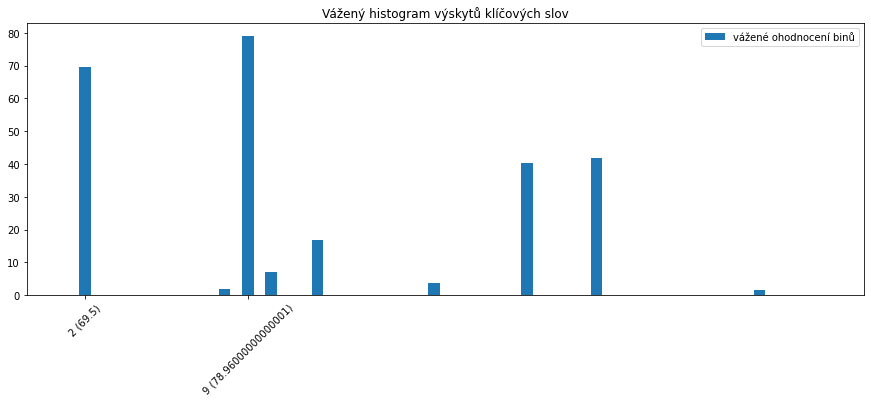

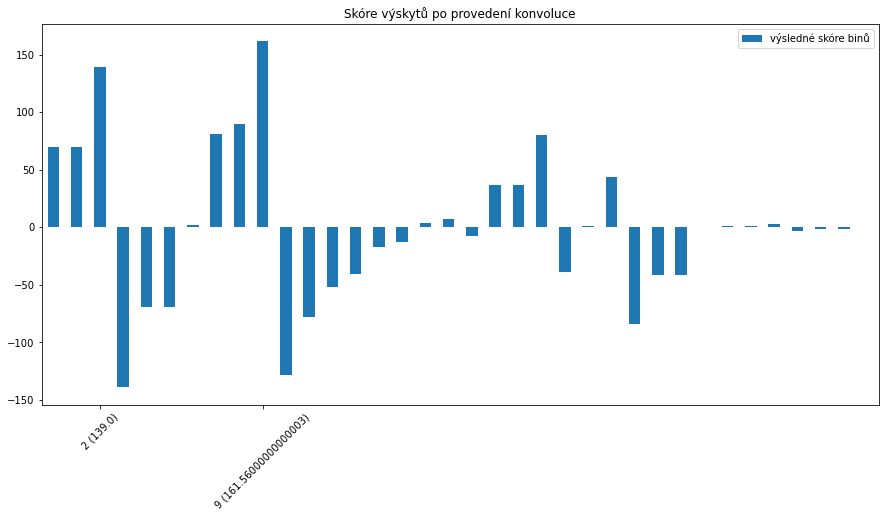

In [228]:
extractor.show_occurrence_distribution(text)

In [53]:
import numpy as np
import matplotlib.pyplot as plt

In [229]:
data_groups = {
    '#0000FF': {'kws': {'Předmět':1}},
    '#FF0000': {'kws': {'Předmět plnění': 10}}, 
    '#00FF00': {'kws': {'Popis': 1}},
    'gray': {'kws': {'Popis předmětu': 10, 'Předmět smlouvy': 10, 'Název veřejné zakázky': 3}}
}

In [235]:
def plot_occurrence_distributions(text, data_groups, legend=['Předmět', 'Předmět plnění', 'Popis', 'ostatní'], subj_range=300):
    bin_size = int(subj_range / 3)
    bins = int(len(text) / bin_size) + 1
    
    for grp in data_groups:
        tmp_keywords = data_groups[grp]['kws']
        tmp_extractor = AdvancedSubjectContextExtractor(keywords = tmp_keywords, subj_range = subj_range)
        tmp_occurrences = tmp_extractor.get_all_occurrences(text)
        tmp_df = pandas.DataFrame(tmp_occurrences, columns=['keyword', 'rat', 'occ'])
        tmp_hist = numpy.histogram(tmp_df['occ'], bins, weights=tmp_df['rat'], range=(0, len(text)))[0]
        data_groups[grp] = {'kws': tmp_keywords, 'ext': tmp_extractor, 'occ': tmp_occurrences, 'his': tmp_hist}
        
    ind = np.arange(bins)
    hist_sum = np.zeros(bins)
    plt.figure(num=None, figsize=(10, 4), dpi=160, facecolor='w', edgecolor='k')
    for grp in data_groups:
        tmp_hist = data_groups[grp]['his']
        tmp_p = plt.bar(ind, tmp_hist, 1, bottom=hist_sum, color=grp)
        hist_sum = hist_sum + tmp_hist
    
    ymax = np.ceil(hist_sum.max()/100)*100
    plt.ylim((0,ymax))
    plt.xlim((0,bins))

    xticks = numpy.argwhere(hist_sum > 0).flatten()
    plt.xticks(xticks)

    for i, v in enumerate(hist_sum):
        if v>0:
            v = round(v, 1)
            decimals = len(str(v).split('.')[0])
            plt.text(i - 0.5*decimals, v + 2, str(v))
    
    plt.legend(legend)
    plt.xlabel('Biny')
    plt.ylabel('Ohodnocení')
    plt.title('Vážený histogram výskytů klíčových slov')
    plt.show()
    
    score = numpy.convolve(hist_sum, numpy.array([1, 1, 2, -2, -1, -1]))[2:-3]
    max_score = score.max()
    threshold = max_score * 2 / 3
    top_bins = numpy.argwhere(score > threshold).flatten()

    plt.figure(num=None, figsize=(10, 6), dpi=160, facecolor='w', edgecolor='k')
    plt.bar(ind, score, 1)
    
    # horizontal line indicating the threshold
    plt.plot([0., bins], [threshold, threshold], "k--")

    ymax = np.ceil(score.max()/100)*100
    plt.ylim((-ymax,ymax))
    plt.xlim((0,bins))

    plt.xticks(xticks)
    
    for i, v in enumerate(score):
        if v>threshold:
            v = round(v, 1)
            decimals = len(str(v).split('.')[0])
            plt.text(i - 0.5*decimals, v + 2, str(v))
    v = round(threshold, 1)
    decimals = len(str(v).split('.')[0])
    plt.text(bins + 0.25, v, str(v))

    plt.xlabel('Biny')
    plt.ylabel('Skóre')
    plt.title('Skóre výskytů po provedení konvoluce')
    plt.show()

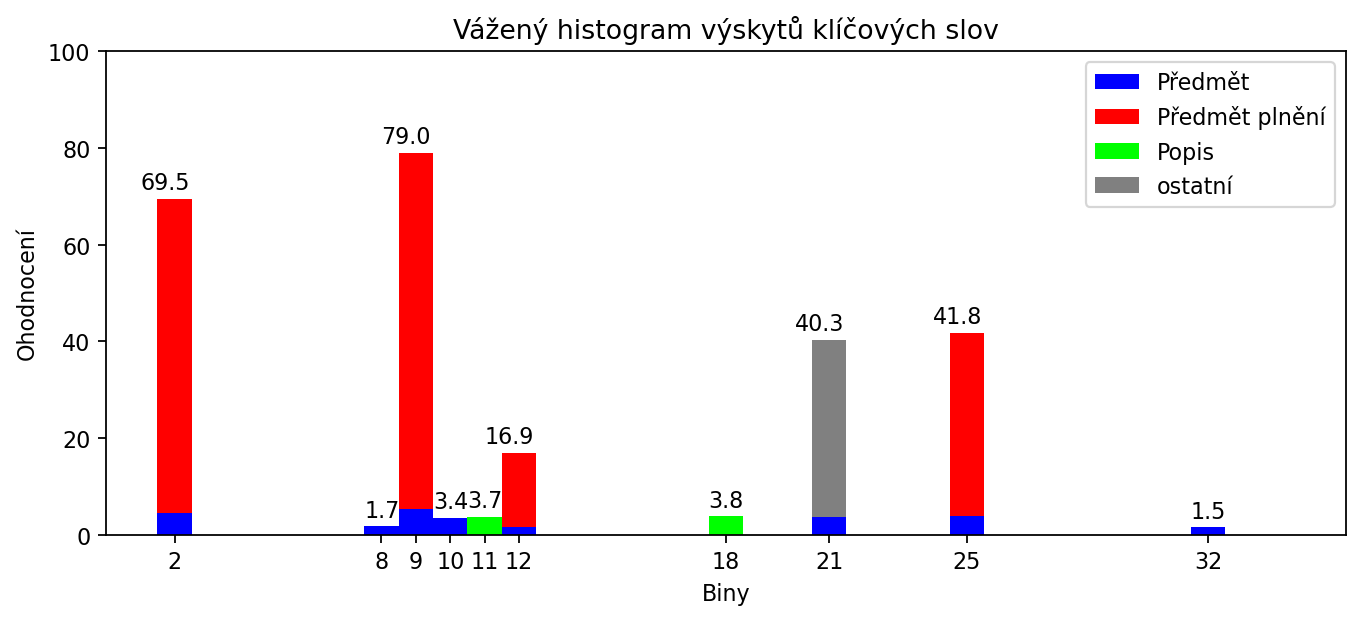

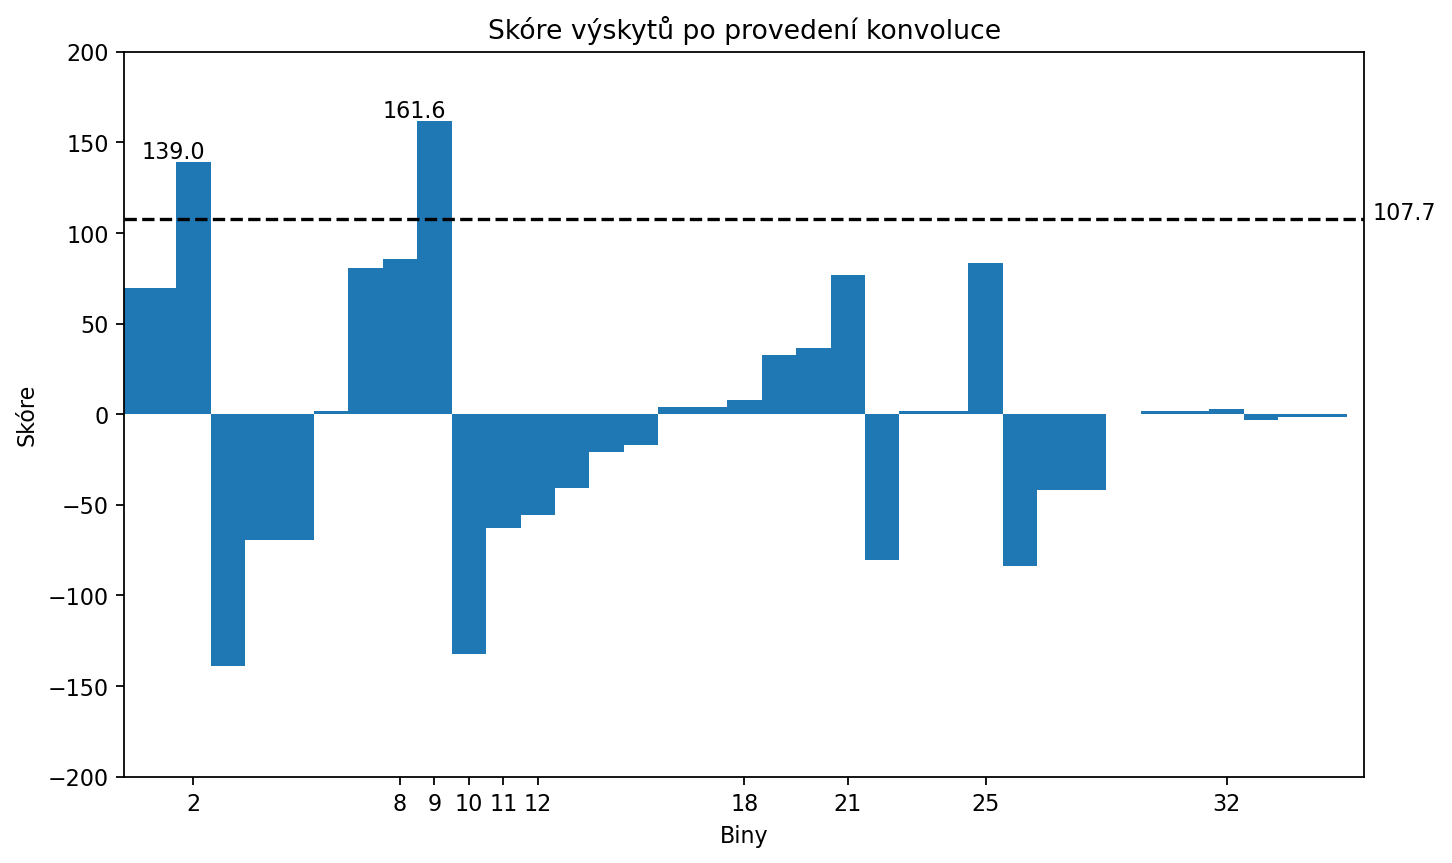

In [236]:
plot_occurrence_distributions(text, data_groups)

In [239]:
data_groups['#FF0000']

{'kws': {'Předmět plnění': 10},
 'ext': <utils.context_extraction.AdvancedSubjectContextExtractor at 0x1e697458788>,
 'occ': [{'keyword': 'PŘEDMĚT PLNĚNÍ', 'rat': 65.0, 'occ': 228},
  {'keyword': 'PŘEDMĚT PLNĚNÍ', 'rat': 73.60000000000001, 'occ': 964},
  {'keyword': 'předmět plnění', 'rat': 15.4, 'occ': 1227},
  {'keyword': 'předmět plnění', 'rat': 38.0, 'occ': 2453}],
 'his': array([ 0. ,  0. , 65. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , 73.6,  0. ,
         0. , 15.4,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. , 38. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ])}

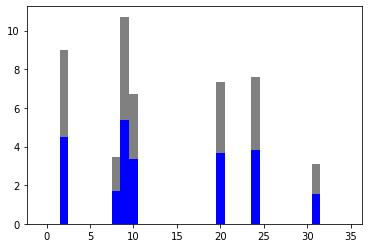

In [68]:
p1 = plt.bar(ind, mod_hist, width, color='b')
p2 = plt.bar(ind, cer_hist, width, bottom=mod_hist, color='gray')
# p3 = plt.bar(ind, zel_hist, width, 
#              bottom=np.array(dataset[1])+np.array(dataset[2]), color='g')
plt.show()

In [50]:

score = numpy.convolve(hist[0], numpy.array([1, 1, 2, -2, -1, -1]))[2:-3]

max_score = score.max()
threshold = max_score * 2 / 3
top_bins = numpy.argwhere(score > threshold).flatten()

ticks = [str(b) + ' (' + str(s) + ')' for b, s in zip(top_bins, [hist[0][i] for i in top_bins])]
ax = pandas.DataFrame(hist[0]).plot.bar(figsize=(10,4), xticks=top_bins)
ax.set_title('Vážený histogram výskytů klíčových slov')
ax.set_xticklabels(ticks, rotation=45)
ax.legend(['vážené ohodnocení binů'])
ticks = [str(b) + ' (' + str(s) + ')' for b, s in zip(top_bins, [score[i] for i in top_bins])]
ax = pandas.DataFrame(score).plot.bar(figsize=(10, 5), xticks=top_bins)
ax.set_title('Skóre výskytů po provedení konvoluce')
ax.set_xticklabels(ticks, rotation=45)
ax.legend(['výsledné skóre binů'])


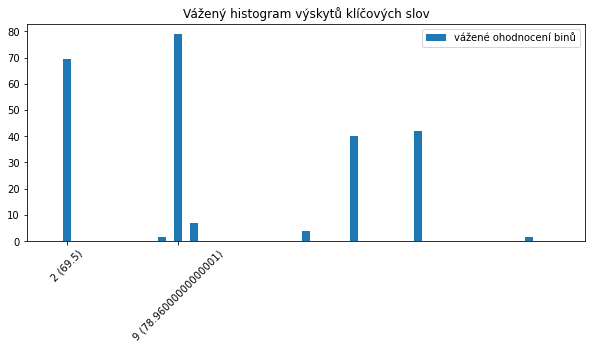

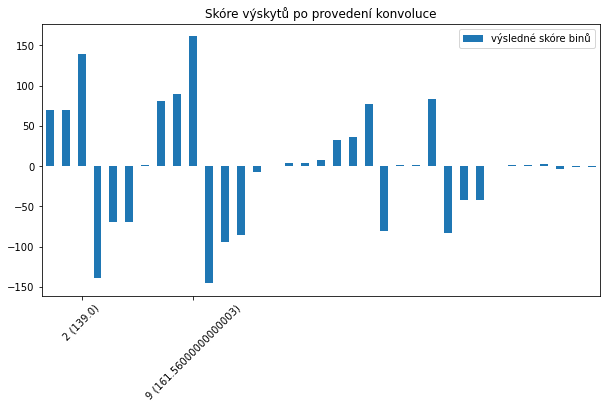

In [52]:
plot_occurences_distribution(extractor.get_all_occurrences(text), text)

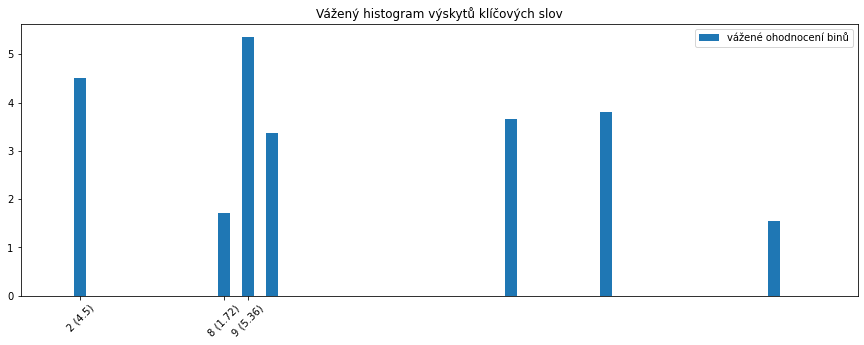

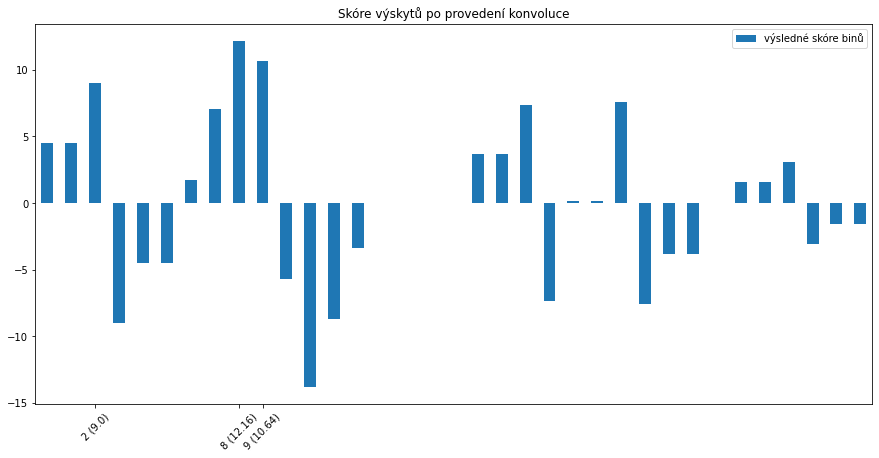

In [45]:
mod_extractor.show_occurrence_distribution(text)

In [21]:
extractor.get_subject_context_starts(df_contracts.loc[index,'text'])

[1532]

In [22]:
for subj_context in df_contracts.loc[index, 'subj_context']:
    print(subj_context[:min(1000, len(subj_context))])
    print('====================')

PŘEDMĚT SMLOUVY
Zhotovitel se zavazuje k provedení stavebních prací v rámci projektu „Stezka pro cyklisty - k. ú. Starý Mateřov“ (dále jen
„veřejná zakázka“).

Objednatel se zavazuje předmět smlouvy převzít bez vad a nedodělků v době předání a zaplatit za ně zhotoviteli cenu podle
smlouvy a podmínek dohodnutých ve smlouvě.

Předmětem plnění je Stezka pro cyklisty — k. ú. Starý Mateřov v souladu s podmínkami provádění díla stanovenými projektovou

dokumentací. Dílo bude provedeno v rozsahu projektové dokumentace, zadávací dokumentace a položkového rozpočtu —
položkového výkazu výměr oceněného uchazečem.



In [25]:
text = df_contracts.loc[index, 'text']
print(text)

=======================2017126-115451.pdf=======================
SMLOUVA O DÍLO č. 1/2016

Smluvní strany
Objednatel (zadavatel): Obec Starý Mateřov .
ša Starý Mateřov 38, 530 02 Starý Mateřov
Identifikační číslo: 00274330
zastoupená: Pavlem Sehnoutkem, starostou obce
Zhotovitel: BW — Stavitelství, s.r.o.
se sídlem: Vysokomýtská 718, 534 01 Holice
Identifikační číslo: 15049752
DIČ: CZ15049752

zapsán v OR u KS v Hradci Králové oddíl C, vložka 332

Oprávněný zástupce:
- ve věcech smluvních: Ing. Pavel Pejcha, MBA
- ve věcech technických: David Vinopal
- ve věcech stavby: David Vinopal
Bankovní spojení: Československá obchodní banka, a. s.
Číslo účtu: 263835624/0300
X
ZÁKLADNÍ USTANOVENÍ

Smluvní strany se dohodly, že tento závazkový vztah a vztahy z něj vyplývající se řídí Občanským zákoníkem, a to podle ust. $
2586 a násl, tohoto zákoníku, v platném znění.

Smluvní strany prohlašují, že údaje uvedené ve smlouvě a taktéž oprávnění k podnikání jsou v souladu s právní skutečností v době
u

In [34]:
extractor.get_subject_context_start(text)

272726

In [35]:
extractor.get_subject_context_end(text, 272726)

275009

In [36]:
print(text[272726: 275009])

Vymezení předmětu veřejné zakázky 


2.1. Obecné vymezení předmětu veřejné zakázky 
Dle ustanovení § 26 a § 53 zákona se jedná o podlimitní veřejnou zakázku na stavební práce 


s názvem „Silnice III/26322 - Mlýny“ 


 


Klasifikace předmětu veřejné zakázky 


kód CPV: 45233141-9 - Práce na údržbě silnic  


kód CPV: 45233223-8 - Obnova povrchu vozovky 


kód CPV: 45233290-8 - Instalace a montáž dopravního značení 


kód CPV: 50230000-6 - Opravy a údržba silnic a dalších zařízení a související služby 


Předmět plnění této veřejné zakázky: 


Předmětem této veřejné zakázky je velkoplošná oprava silnice III/26322 mezi Českou 


Kamenicí a Kytlicí se začátkem na rozhraní Libereckého a Ústeckého kraje s koncem na 


začátku obce Kytlice – Mlýny. V celém úseku km 1,290 – km 3,645 budou provedeny 


údržbové práce v podobě souvislé údržby povrchu spočívající v pokládce asfaltových vrstev. 


Napojení na stávající komunikace v místech přiléhajících zpevněných ploch a křižovatek bude 



htt

In [682]:
df_contracts.at[index, 'subj_context2']

'  Článek II\n\nPředmět smlouvy\n(1)     Na základě této smlouvy se prodávající zavazuje dodat kupujícímu zboží a převést na něj vlastnické právo ke zboží, za podmínek dohodnutých v dalších ustanoveních smlouvy. Kupující se zavazuje zboží bez vad předané převzít a zaplatit za ně prodávajícímu kupní cenu, specifikovanou v čl. IV smlouvy, na základě dohodnutých platebních podmínek.\n(2)     Předmětem smlouvy je dodávka nových školících pomůcek a zařízení, v souladu s potřebami a požadavky kupujícího. Podrobná specifikace předmětu smlouvy je obsažena v Příloze č. 1 smlouvy. Prodávající se zavazuje dodat kupujícímu zboží ve smluveném množství, jakosti, provedení, termínech a ceně. Dále je prodávající povinen předat kupujícímu doklady, které se ke zboží vztahují a umožnit kupujícímu nabýt vlastnické právo ke zboží. Součástí předmětu smlouvy je též doprava předmětu smlouvy na místo plnění, jeho montáž, uvedení do provozu a zaškolení pracovníků kupujícího.\n(3) Prodávající se zavazuje umožnit

In [681]:
df_contracts.at[index, 'subj_context2'] = """  Článek II

Předmět smlouvy
(1)     Na základě této smlouvy se prodávající zavazuje dodat kupujícímu zboží a převést na něj vlastnické právo ke zboží, za podmínek dohodnutých v dalších ustanoveních smlouvy. Kupující se zavazuje zboží bez vad předané převzít a zaplatit za ně prodávajícímu kupní cenu, specifikovanou v čl. IV smlouvy, na základě dohodnutých platebních podmínek.
(2)     Předmětem smlouvy je dodávka nových školících pomůcek a zařízení, v souladu s potřebami a požadavky kupujícího. Podrobná specifikace předmětu smlouvy je obsažena v Příloze č. 1 smlouvy. Prodávající se zavazuje dodat kupujícímu zboží ve smluveném množství, jakosti, provedení, termínech a ceně. Dále je prodávající povinen předat kupujícímu doklady, které se ke zboží vztahují a umožnit kupujícímu nabýt vlastnické právo ke zboží. Součástí předmětu smlouvy je též doprava předmětu smlouvy na místo plnění, jeho montáž, uvedení do provozu a zaškolení pracovníků kupujícího.
(3) Prodávající se zavazuje umožnit osobám oprávněným k výkonu kontroly projektu, z něhož bude zakázka hrazena, provést kontrolu dokladů souvisejících s plněním zakázky a to minimálně do 31. 12. 2025.

(4) Prodávající se zavazuje uchovávat veškeré originály účetních dokladů a originály dalších dokumentů souvisejících s realizací projektu, z něhož bude zakázka hrazena, dle zákona č. 563/1991 Sb., o účetnictví, ve znění pozdějších předpisů, minimálně do 31. 12. 2025. 

(5) Prodávající se zavazuje řídit se v případě publicity na všech dokumentech souvisejících s projektem, z něhož bude zakázka hrazena, pravidly publicity projektů financovaných z programu OPVK a pravidly vizuální identity ESF v ČR dle příručky pro příjemce finanční podpory projektů OPVK.

(6) Prodávající se zavazuje dodržovat při plnění předmětu smlouvy opatření bezpečnosti, požární ochrany a ochrany zdraví při práci.

(7) Prodávající se zavazuje splnit předmět smlouvy prostřednictvím osob s potřebnou kvalifikací a odborností.

Článek III
"""

In [650]:
df_subj_context2 = df_contracts.loc[0:39]['subj_context2']
df_subj_context2

id
0     \nSmlouva nabývá platnosti a účinnosti dnem po...
1     \nTito uvedení zástupci jsou oprávněni jednat ...
2     \njménem zadavatele\n\n \n\n2. Předmět veřejné...
3     \n(dále jen „zhotovitel “ nebo „projektant“)\n...
4     \nvyhotovil tuto písemnou zprávu.\n\n1. Předmě...
5     \nprohlášení nebo v souvislosti s ní druhé sml...
6     \nmluvní straně vznikne.\nČlánek 2\nPředmět Sm...
7     \nOdůvodnění: Veřejnou zakázku malého rozsahu....
8     \nIdentifikace veřejné zakázky\n\nNázev veřejn...
9     \nvěstníku EU, na veřejnou zakázku „Programové...
10    \nJana Velíšková, tel. + 420 973 225 210.\n\n2...
11    \npovinen dodržet zásady podle $ 6 ZZVZ.\n\n2....
12    \ntéto Smlouvy a je odborně způsobilý ke splně...
13    \nrozhodl o výběru dodavatele k veřejné zakázc...
14    \nStrana 2\n\nII.\nPředmět plnění\n1. Předměte...
15    \nIdentifikace veřejné zakázky\n\n\tNázev veře...
16    \nOdůvodnění: Veřejnou zakázku malého rozsahu....
17    \nNabídku lze podat pouze elektronicky 